# Try to add a nifty model for sampling the input map

PASSBAND: gaussian 150.0 30


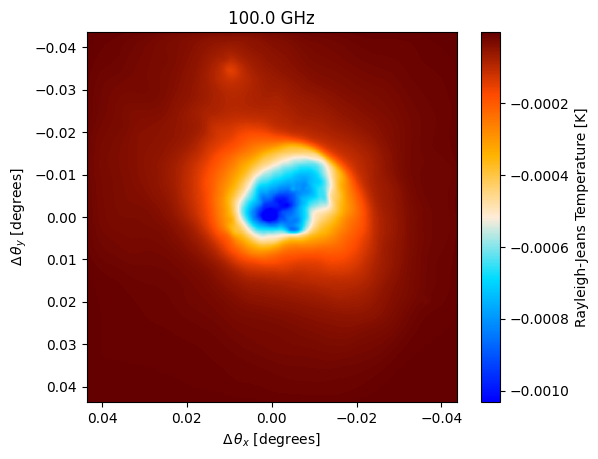

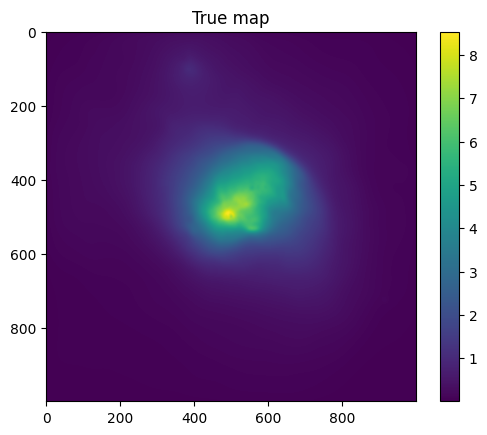

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

# input_map.data[0] = input_map.data[0]*0. + input_map.data[0].mean()

input_map.to(units="K_RJ").plot()
plt.show()


# Sava mapdata as jax array
mapdata_input = np.float64((input_map.data[0].T)*-1e7)

plt.imshow(mapdata_input)
plt.colorbar()
plt.title('True map')
plt.show()

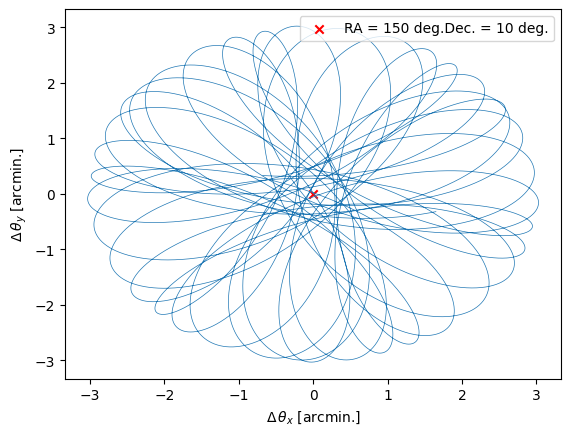

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod_truthmap = sim_truthmap.run()

2024-07-30 09:04:24.496 INFO: Constructed instrument.
2024-07-30 09:04:24.497 INFO: Constructed plan.
2024-07-30 09:04:24.498 INFO: Constructed site.
2024-07-30 09:04:25.027 INFO: Constructed boresight.
2024-07-30 09:04:25.278 INFO: Constructed offsets.


Initialized base in 782 ms.


Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

MARKER
(64, 1000, 1000)
(64,)
(1, 1000, 1000)
PASSBAND: gaussian 90.0 30
HERE n_side: 3
INPUTS map_power:
dx[band_mask] [[-1.9628652e-04 -1.9276464e-04 -1.8971233e-04 ...  4.7382721e-04
   4.7687953e-04  4.7993180e-04]
 [-2.7118466e-04 -2.6813237e-04 -2.6484532e-04 ...  3.9798603e-04
   4.0103839e-04  4.0409074e-04]
 [-2.4559547e-04 -2.4230835e-04 -2.3878644e-04 ...  4.2851540e-04
   4.3156778e-04  4.3462013e-04]
 ...
 [-4.0474121e-04 -4.0145448e-04 -3.9816773e-04 ...  2.2961208e-04
   2.3266416e-04  2.3571622e-04]
 [-5.1400432e-04 -5.1071699e-04 -5.0742965e-04 ...  1.8691758e-04
   1.8973541e-04  1.9302288e-04]
 [-7.4873149e-04 -7.4544450e-04 -7.4215751e-04 ... -8.7813336e-05
  -8.4760992e-05 -8.1708640e-05]]
dy[band_mask] [[ 9.6262323e-05  9.6013559e-05  9.5849646e-05 ... -9.4737858e-05
  -9.3942297e-05 -9.2972456e-05]
 [ 1.0961054e-04  1.0944663e-04  1.0916806e-04 ... -8.6159685e-05
  -8.5334323e-05 -8.4453910e-05]
 [ 3.7784415e-05  3.7595251e-05  3.7291429e-05 ... -1.5610579e-04
  

Sampling map (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]

RESULT map_power [[-6.56771738e-04 -6.60748153e-04 -6.67359082e-04 ... -2.68545035e-05
  -2.67658709e-05 -2.67025314e-05]
 [-3.99484977e-04 -4.09608171e-04 -4.20327813e-04 ... -3.79259370e-05
  -3.73892317e-05 -3.68689950e-05]
 [-4.69640048e-04 -4.80280440e-04 -4.91019858e-04 ... -2.37934620e-05
  -2.36059908e-05 -2.34570455e-05]
 ...
 [-1.45129352e-05 -1.46293374e-05 -1.47483395e-05 ... -8.30157164e-05
  -8.23462120e-05 -8.16577910e-05]
 [-3.11619646e-05 -3.17938468e-05 -3.24195089e-05 ... -1.13047132e-05
  -1.12496137e-05 -1.11867393e-05]
 [-9.03977474e-06 -9.50357436e-06 -9.95019837e-06 ... -8.78001862e-04
  -8.91508349e-04 -9.07013011e-04]]
PASSBAND: gaussian 90.0 30
PASSBAND: gaussian 90.0 30


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]

(1, 1000, 1000)
mean: -8.726027824180198e-05


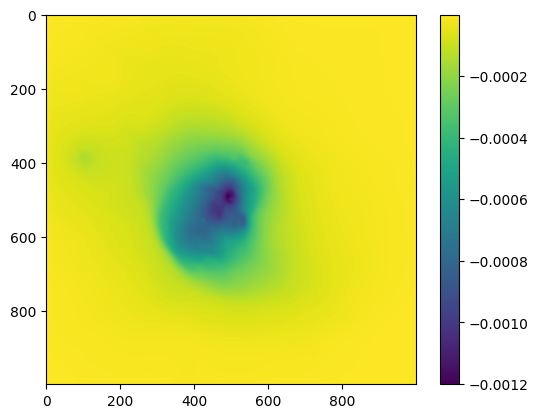

In [5]:
from maria.map.mappers import BinMapper

mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

# output_truthmap.plot()

# mapdata_truth = np.float64((output_truthmap.data[0])*-1e4)
# mapdata_truth = np.float64(-1.*(output_truthmap.data[0]))
# mapdata_truth = np.float64(output_truthmap.data[0])
mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean
# mapdata_truth = mapdata_truth*0. + mapdata_truth.mean()


print(mapdata_truth.shape)
print("mean:", mapdata_truth.mean())

plt.imshow(mapdata_truth[0])
plt.colorbar()

# Next, initialise nifty prior model

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-07-30 09:04:34.110 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-07-30 09:04:34.112 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-07-30 09:04:34.175436: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
# dims = (128, 128)
dims = (1000, 1000)
# dims = (500, 500)

# Map model

# correlated field zero mode GP offset and stddev
# mean: -0.0001326779640292624
# mean: -8.726027824180198e-05
# cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(1e-5, 1e-5))
cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1.0e0, 1e-1), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(1e-3, 1e-4),
    # loglogavgslope=(-1.5e0, 1e0), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    loglogavgslope=(-3e0, 5e-1), 
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [8]:
# jax compatible rewrite if beams.separably_filter
@jax.jit
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    # u, s, v = np.linalg.svd(F)
    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # TODO: jax convolution works slightly different than in scipy. Fix here!
        # filtered_image += s[m] * jax.scipy.signal.convolve(
        #     jax.scipy.signal.convolve(data, u[:, m], ), v[m],
        # )
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        # step1 = jax.scipy.signal.convolve(data, u_kernel.T, mode='same')
        # print("step1 shape", step1.shape)
        # step2 = jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')
        # print("step2 shape", step2.shape)
        # print("s[m] shape", s[m].shape)
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

        # if np.abs(F - effective_filter).mean() < tol:
        # if jax.numpy.abs(F - effective_filter).mean() < tol:
        #     break

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [9]:
@jax.jit
def construct_beam_filter(fwhm, res, buffer=1):
    """
    Make a beam filter for an image.
    """

    # if beam_profile is None:
    #     # beam_profile = lambda r, r0: np.where(r <= r0, 1., 0.)

    #     # a top hat
    #     def beam_profile(r, r0):
    #         return np.exp(-((r / r0) ** 16))

    filter_width = buffer * fwhm

    # n_side = jax.numpy.maximum(filter_width / res, 3).astype(int) # n_side = 3

    filter_side = jax.numpy.linspace(-filter_width / 2, filter_width / 2, 3)
    X, Y = jax.numpy.meshgrid(filter_side, filter_side, indexing="ij")
    R = jax.numpy.sqrt(jax.numpy.square(X) + jax.numpy.square(Y))
    F = jax.numpy.exp(-((R / (fwhm / 2)) ** 16))

    return F / F.sum()

In [10]:
from maria.constants import k_B
from maria.instrument import beams

@jax.jit
def sample_maps(sim_truthmap, dx, dy, resolution, x_side, y_side):

    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))
    pbar = instrument.bands

    for band in pbar:
        band_mask = instrument.dets.band_name == band.name

        nu = jax.numpy.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            sim_truthmap,
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)


        nu_passband = jax.numpy.exp(jax.numpy.log(0.5) * (2 * (nu - 90.) / 30.) ** 2)
        power_map = (
            1e12
            * k_B
            * jax.numpy.trapezoid(nu_passband[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = construct_beam_filter(fwhm=nu_fwhm, res=resolution)
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            # Need to invert x_side and y_side for jax interpolation:
            (jax.numpy.flip(x_side), jax.numpy.flip(y_side)), # length N=2 sequence of arrays with grid coords
            # jax.numpy.flip(sim_truthmap[0]),
            jax.numpy.flip(filtered_power_map), # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask]), jax.numpy.array(dy[band_mask])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

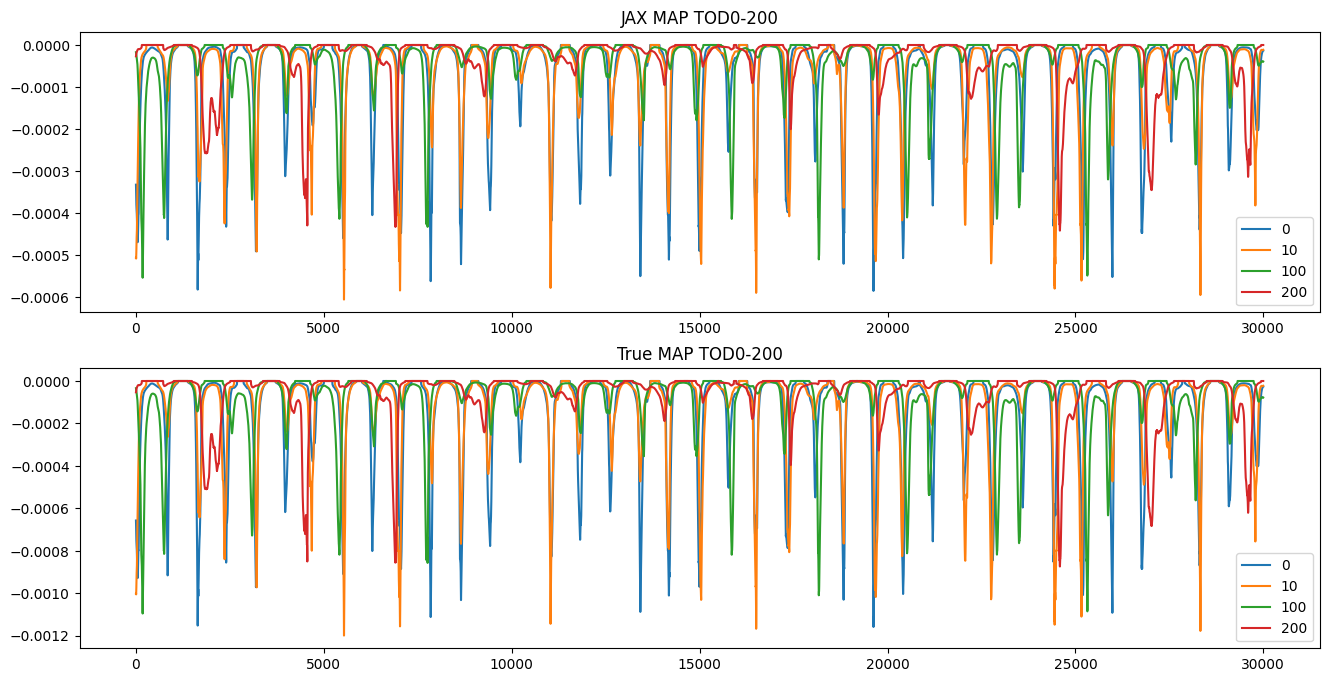

In [11]:

jax_tods = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

In [12]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims[0], dims[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init, domain=jft.Vector(gp_map.domain))

    def __call__(self, x):
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
# noise_cov_inv = lambda x: 1e-1**-2 * x # 10% noise
noise_cov_inv_map = lambda x: 1e-4**-2 * x # 10% noise
noise_cov_inv_tod = lambda x: 1e-8**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

lh = lh_tod + lh_map
# lh = lh_map
# lh = lh_tod

lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [13]:
key, sub = random.split(key)
print(lh_map_grad(jft.random_like(sub, lh_map.domain)))
print(lh_tod_grad(jft.random_like(sub, lh_tod.domain)))

Vector(
	{'cfmapax1fluctuations': Array(8734391.06671382, dtype=float64),
	 'cfmapax1loglogavgslope': Array(548865.12630159, dtype=float64),
	 'cfmapxi': Array([[ 1.11464435e+03, -6.94033542e+06,  2.69502995e+06, ...,
	        -2.19462961e+05, -9.46481865e+05,  2.10468422e+06],
	       [-4.29410260e+06,  3.56474096e+05, -1.02299605e+06, ...,
	        -6.69939156e+05,  3.86101434e+05,  2.85663911e+06],
	       [-7.67815607e+05,  5.08728497e+05, -7.57415023e+04, ...,
	         1.94813637e+04,  1.14443039e+04, -4.47072283e+05],
	       ...,
	       [ 3.43848964e+04, -2.47552743e+05,  2.52547311e+04, ...,
	         4.09561642e+04,  1.26956419e+05,  5.49019883e+05],
	       [ 8.09793467e+05,  2.25792180e+05,  6.04604092e+05, ...,
	        -3.14091401e+05, -1.47969246e+05, -1.64794881e+05],
	       [-1.53741388e+07,  2.40537966e+06, -2.57906873e+06, ...,
	        -4.64725505e+05, -6.21264744e+05,  6.44706440e+05]],      dtype=float64),
	 'cfmapzeromode': Array(204.7180151, dtype=float64)}
)


# MAP fit

In [14]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
delta = 1e-12 # tod
# delta = 1e-10 # tod simple

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100 # map
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=200 # tod
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

/scratch/users/jwuerzin/.local/lib/python3.11/site-packages/nifty8/re/model.py:164: UserWarning: drawing white parameters;
to silence this warning, overload the `init` method
  warn(msg)
OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:3.838577e+01 ➽:1.000003e-06
M: Iteration 1 ⛰:+2.667555e+14 Δ⛰:2.998645e+15
M: →:1.0 ↺:False #∇²:12 |↘|:1.573794e+01 ➽:1.000003e-06
M: Iteration 2 ⛰:+4.256700e+13 Δ⛰:2.241885e+14
M: →:1.0 ↺:False #∇²:18 |↘|:1.324019e+01 ➽:1.000003e-06
M: Iteration 3 ⛰:+1.383614e+13 Δ⛰:2.873086e+13
M: →:1.0 ↺:False #∇²:24 |↘|:6.029367e+00 ➽:1.000003e-06
M: Iteration 4 ⛰:+1.006416e+13 Δ⛰:3.771978e+12
M: →:1.0 ↺:False #∇²:30 |↘|:4.886591e+00 ➽:1.000003e-06
M: Iteration 5 ⛰:+8.364877e+12 Δ⛰:1.699282e+12
M: →:1.0 ↺:False #∇²:39 |↘|:2.127319e+01 ➽:1.000003e-06
M: Iteration 6 ⛰:+4.949707e+12 Δ⛰:3.415170e+12
M: →:1.0 ↺:False #∇²:45 |↘|:1.943923e+00 ➽:1.000003e-06
M: Iteration 7 ⛰:+4.492904e+12 Δ⛰:4.568029e+11
M: →:1.0 ↺:False #∇²:51 |↘|:3.141334e+00 ➽:1.000003e-06
M: Iterat

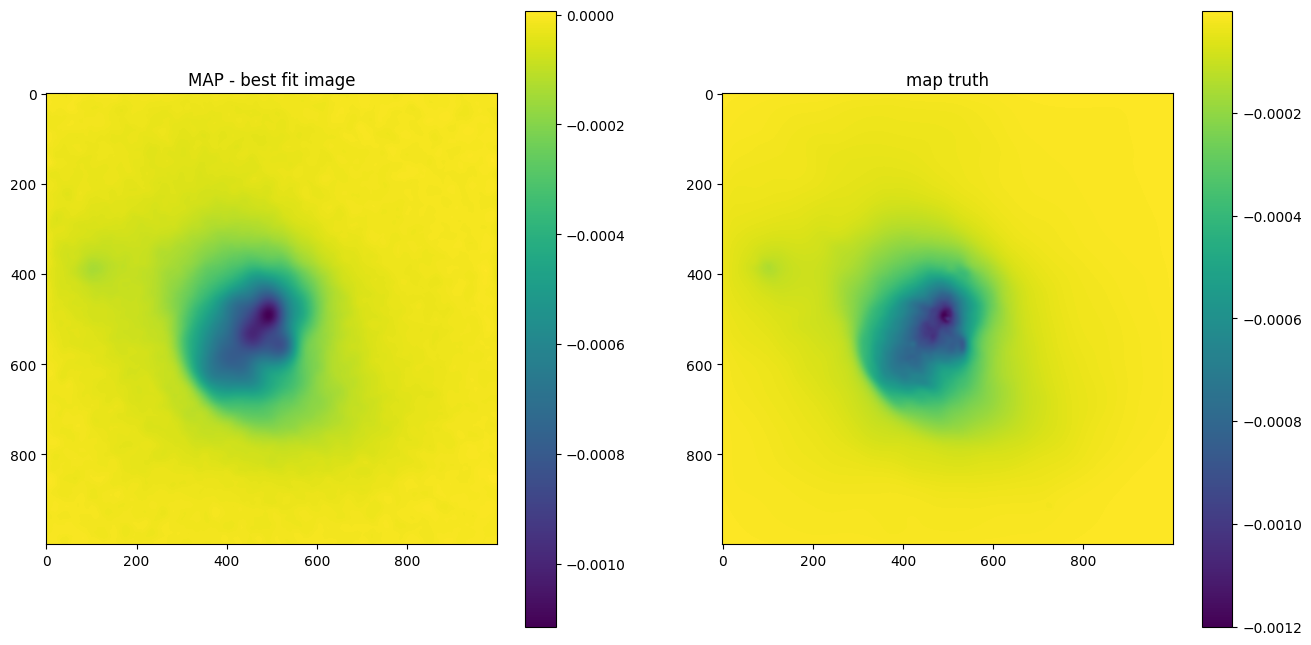

In [15]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( mapdata_truth[0] )
axes[1].title.set_text('map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

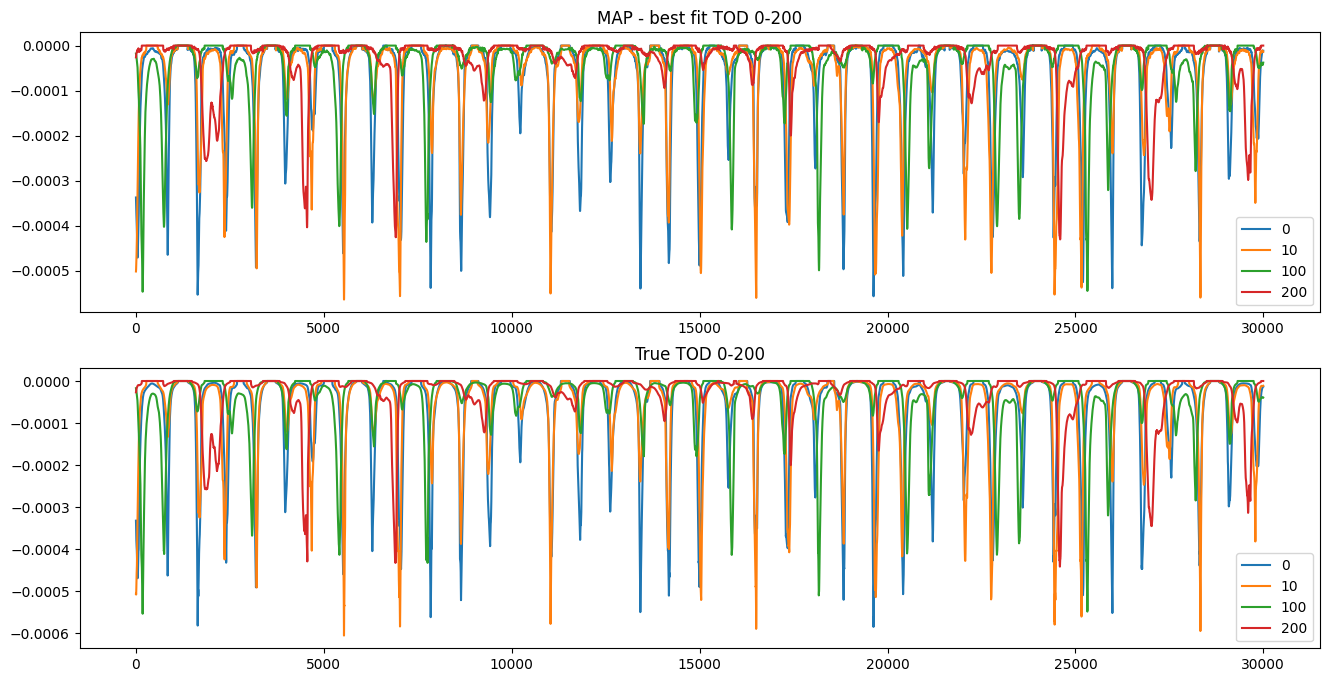

In [16]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(pred_tods[i], label=i)
    # im1 = axes[1].plot(tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods[i], label=i)
    
axes[0].title.set_text(f'MAP - best fit TOD 0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True TOD 0-{i}')
axes[1].legend()

plt.show()

In [17]:
assert False

AssertionError: 

## Full nifty fit:

/scratch/users/jwuerzin/.local/lib/python3.11/site-packages/nifty8/re/model.py:164: UserWarning: drawing white parameters;
to silence this warning, overload the `init` method
  warn(msg)
OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+7.0445e+15 Δ⛰:inf ➽:1.0000e-03
SL: Iteration 1 ⛰:+3.4177e+15 Δ⛰:3.6269e+15 ➽:1.0000e-03
SL: Iteration 2 ⛰:+2.3675e+15 Δ⛰:1.0502e+15 ➽:1.0000e-03
SL: Iteration 3 ⛰:+1.7694e+15 Δ⛰:5.9806e+14 ➽:1.0000e-03
SL: Iteration 4 ⛰:+1.4048e+15 Δ⛰:3.6460e+14 ➽:1.0000e-03
SL: Iteration 5 ⛰:+1.3265e+15 Δ⛰:7.8303e+13 ➽:1.0000e-03
SL: Iteration 6 ⛰:+1.1203e+15 Δ⛰:2.0622e+14 ➽:1.0000e-03
SL: Iteration 7 ⛰:+1.0196e+15 Δ⛰:1.0068e+14 ➽:1.0000e-03
SL: Iteration 8 ⛰:+9.7089e+14 Δ⛰:4.8729e+13 ➽:1.0000e-03
SL: Iteration 9 ⛰:+8.8667e+14 Δ⛰:8.4221e+13 ➽:1.0000e-03
SL: Iteration 10 ⛰:+8.4626e+14 Δ⛰:4.0413e+13 ➽:1.0000e-03
SL: Iteration 11 ⛰:+7.6189e+14 Δ⛰:8.4373e+13 ➽:1.0000e-03
SL: Iteration 12 ⛰:+7.3208e+14 Δ⛰:2.9803e+13 ➽:1.0000e-03
SL: Iteration 13 ⛰:+6.9153e+14 Δ⛰:4.0553e+13 ➽:1.

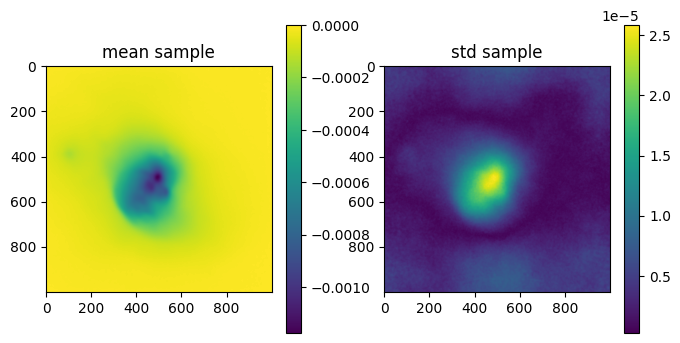

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+2.1249e+13 Δ⛰:inf ➽:1.0000e-03
SL: Iteration 1 ⛰:+4.0780e+12 Δ⛰:1.7171e+13 ➽:1.0000e-03
SL: Iteration 2 ⛰:+1.9918e+12 Δ⛰:2.0863e+12 ➽:1.0000e-03
SL: Iteration 3 ⛰:+1.5034e+12 Δ⛰:4.8843e+11 ➽:1.0000e-03
SL: Iteration 4 ⛰:+9.4556e+11 Δ⛰:5.5780e+11 ➽:1.0000e-03
SL: Iteration 5 ⛰:+5.9598e+11 Δ⛰:3.4959e+11 ➽:1.0000e-03
SL: Iteration 6 ⛰:+4.9478e+11 Δ⛰:1.0119e+11 ➽:1.0000e-03
SL: Iteration 7 ⛰:+4.3416e+11 Δ⛰:6.0621e+10 ➽:1.0000e-03
SL: Iteration 8 ⛰:+3.6497e+11 Δ⛰:6.9193e+10 ➽:1.0000e-03
SL: Iteration 9 ⛰:+3.2319e+11 Δ⛰:4.1781e+10 ➽:1.0000e-03
SL: Iteration 10 ⛰:+2.8539e+11 Δ⛰:3.7799e+10 ➽:1.0000e-03
SL: Iteration 11 ⛰:+2.0393e+11 Δ⛰:8.1453e+10 ➽:1.0000e-03
SL: Iteration 12 ⛰:+1.9260e+11 Δ⛰:1.1337e+10 ➽:1.0000e-03
SL: Iteration 13 ⛰:+1.6680e+11 Δ⛰:2.5794e+10 ➽:1.0000e-03
SL: Iteration 14 ⛰:+1.3407e+11 Δ⛰:3.2729e+10 ➽:1.0000e-03
SL: Iteration 15 ⛰:+1.2600e+11 Δ⛰:8.0705e+09 ➽:1.0000e-03
SL: Iteration 16 ⛰:+1.2048e+11 Δ⛰:5.5288e+09 ➽:1.0000e-03
SL: 

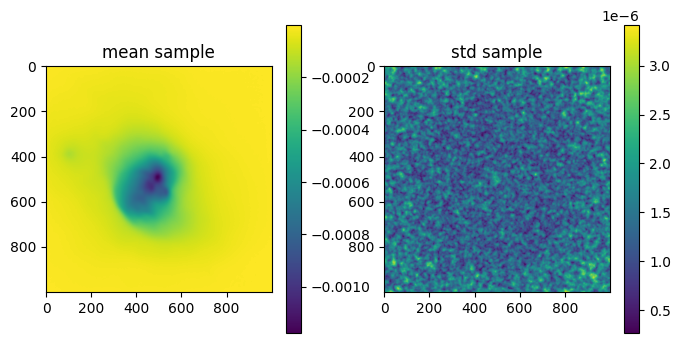

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+3.7500e+12 Δ⛰:inf ➽:1.0000e-03
SL: Iteration 1 ⛰:+2.1512e+12 Δ⛰:1.5988e+12 ➽:1.0000e-03
SL: Iteration 2 ⛰:+1.3566e+12 Δ⛰:7.9467e+11 ➽:1.0000e-03
SL: Iteration 3 ⛰:+9.7612e+11 Δ⛰:3.8044e+11 ➽:1.0000e-03
SL: Iteration 4 ⛰:+8.3236e+11 Δ⛰:1.4376e+11 ➽:1.0000e-03
SL: Iteration 5 ⛰:+5.7075e+11 Δ⛰:2.6161e+11 ➽:1.0000e-03
SL: Iteration 6 ⛰:+3.8247e+11 Δ⛰:1.8828e+11 ➽:1.0000e-03
SL: Iteration 7 ⛰:+3.2859e+11 Δ⛰:5.3883e+10 ➽:1.0000e-03
SL: Iteration 8 ⛰:+2.6651e+11 Δ⛰:6.2079e+10 ➽:1.0000e-03
SL: Iteration 9 ⛰:+2.3927e+11 Δ⛰:2.7239e+10 ➽:1.0000e-03
SL: Iteration 10 ⛰:+2.1787e+11 Δ⛰:2.1397e+10 ➽:1.0000e-03
SL: Iteration 11 ⛰:+1.4389e+11 Δ⛰:7.3988e+10 ➽:1.0000e-03
SL: Iteration 12 ⛰:+1.2725e+11 Δ⛰:1.6633e+10 ➽:1.0000e-03
SL: Iteration 13 ⛰:+1.1362e+11 Δ⛰:1.3631e+10 ➽:1.0000e-03
SL: Iteration 14 ⛰:+9.2611e+10 Δ⛰:2.1011e+10 ➽:1.0000e-03
SL: Iteration 15 ⛰:+8.9600e+10 Δ⛰:3.0103e+09 ➽:1.0000e-03
SL: Iteration 16 ⛰:+8.0638e+10 Δ⛰:8.9623e+09 ➽:1.0000e-03
SL: 

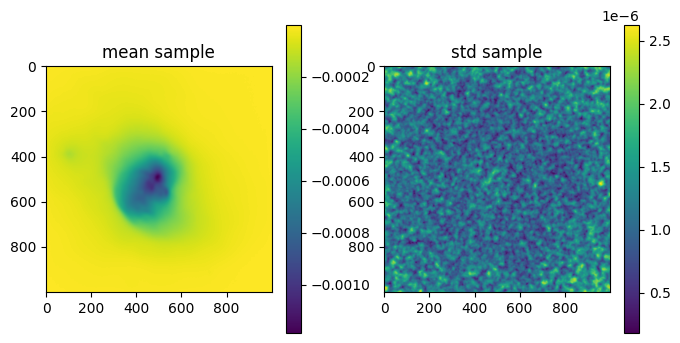

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+9.1167e+12 Δ⛰:inf ➽:1.0000e-03
SL: Iteration 1 ⛰:+2.5308e+12 Δ⛰:6.5859e+12 ➽:1.0000e-03
SL: Iteration 2 ⛰:+1.7637e+12 Δ⛰:7.6711e+11 ➽:1.0000e-03
SL: Iteration 3 ⛰:+1.2439e+12 Δ⛰:5.1973e+11 ➽:1.0000e-03
SL: Iteration 4 ⛰:+7.6623e+11 Δ⛰:4.7772e+11 ➽:1.0000e-03
SL: Iteration 5 ⛰:+6.0880e+11 Δ⛰:1.5743e+11 ➽:1.0000e-03
SL: Iteration 6 ⛰:+3.6459e+11 Δ⛰:2.4421e+11 ➽:1.0000e-03
SL: Iteration 7 ⛰:+3.0567e+11 Δ⛰:5.8927e+10 ➽:1.0000e-03
SL: Iteration 8 ⛰:+2.8186e+11 Δ⛰:2.3809e+10 ➽:1.0000e-03
SL: Iteration 9 ⛰:+1.9955e+11 Δ⛰:8.2307e+10 ➽:1.0000e-03
SL: Iteration 10 ⛰:+1.7739e+11 Δ⛰:2.2163e+10 ➽:1.0000e-03
SL: Iteration 11 ⛰:+1.1464e+11 Δ⛰:6.2752e+10 ➽:1.0000e-03
SL: Iteration 12 ⛰:+1.1053e+11 Δ⛰:4.1091e+09 ➽:1.0000e-03
SL: Iteration 13 ⛰:+8.8436e+10 Δ⛰:2.2090e+10 ➽:1.0000e-03
SL: Iteration 14 ⛰:+7.3104e+10 Δ⛰:1.5332e+10 ➽:1.0000e-03
SL: Iteration 15 ⛰:+6.9691e+10 Δ⛰:3.4132e+09 ➽:1.0000e-03
SL: Iteration 16 ⛰:+5.7833e+10 Δ⛰:1.1858e+10 ➽:1.0000e-03
SL: 

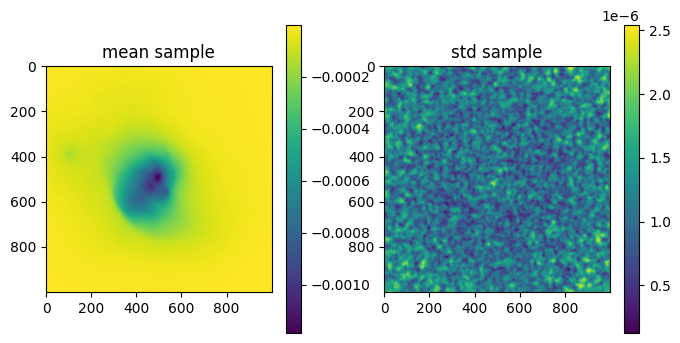

In [21]:
n_it = 4
# delta = 1e-4
delta = 1e-8
n_samples = 8 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

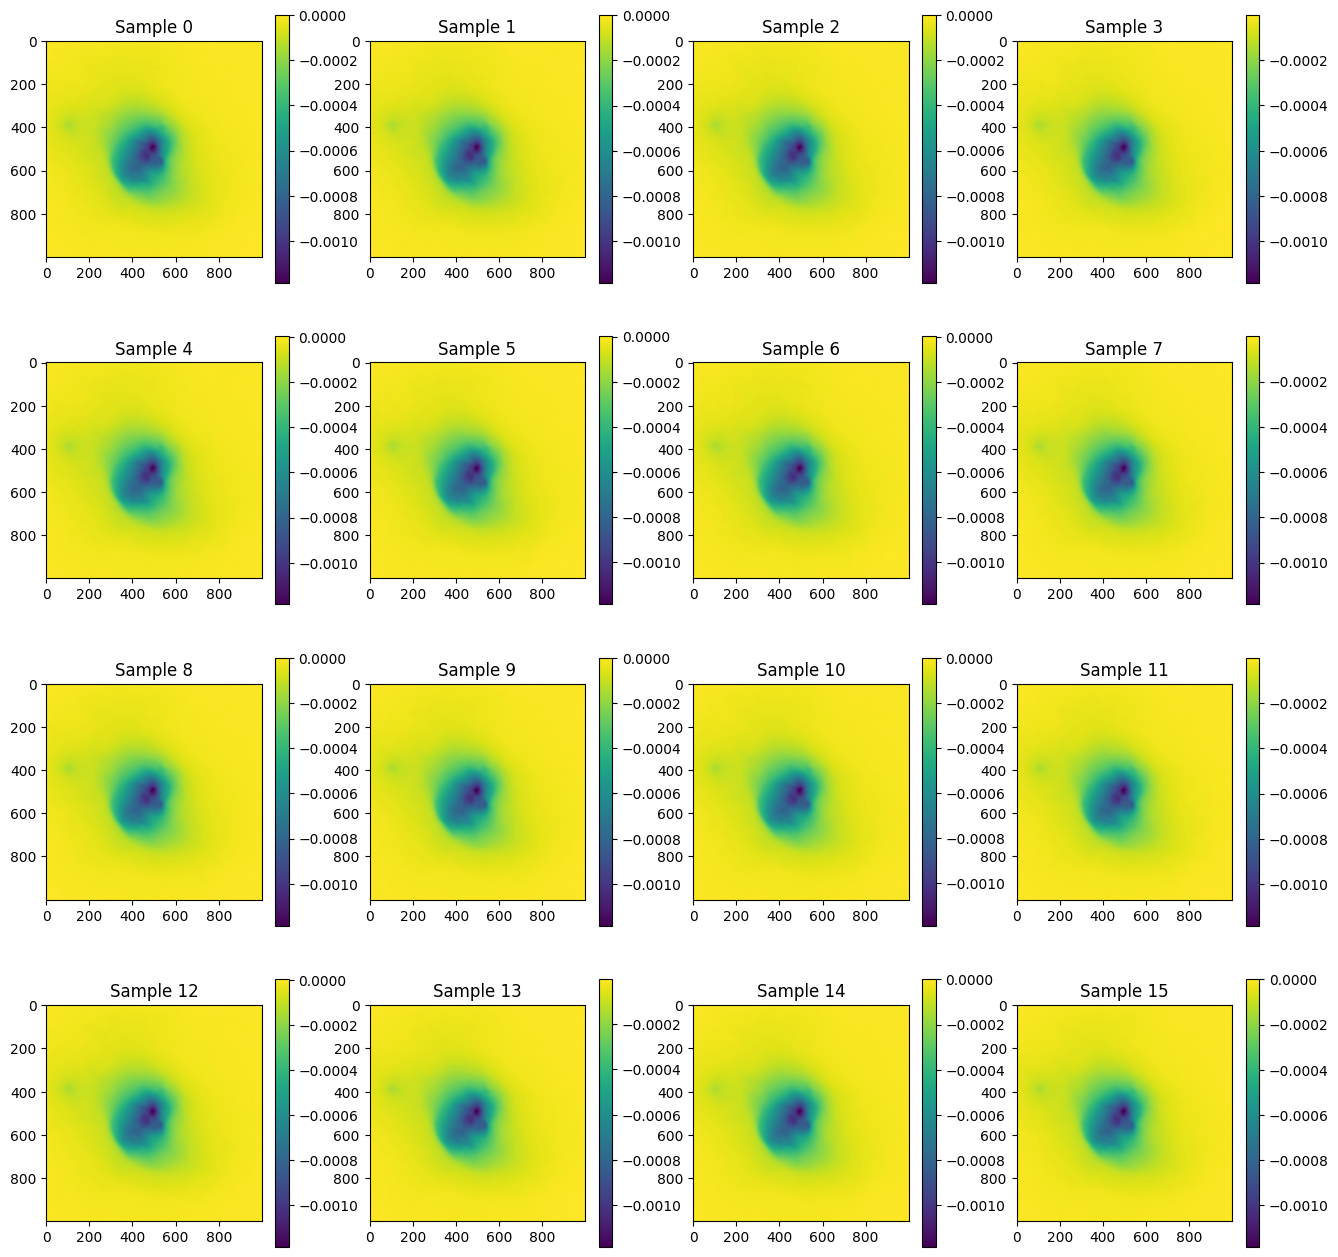

In [22]:
# plot all samples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//4][i%4].imshow(gp_map(s))
    axes[i//4][i%4].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()